In [1]:
import winglets as wl
import pandas as pd
import proplot as plot

import copy

import numpy as np
import winglets as wl
from Geometry import Point
from winglets.conventions import (
    WingletParameters,
    WingSectionParameters,
    OperationPoint,
)
from winglets.optimizer import NAME_CD, NAME_CM
from winglets.utils import get_base_winglet_parametrization

In [2]:
def get_operation_point():

    ALTITUDE = OperationPoint.ALTITUDE.value
    MACH = OperationPoint.MACH.value
    CL = OperationPoint.CL.value

    _dict = {ALTITUDE: 11000, MACH: 0.75, CL: 0.45}

    return _dict

In [3]:
def get_sections():
    """Wing planform sections."""

    WING_AIRFOIL = "naca4412"
    
    CHORD = WingSectionParameters.CHORD.value
    LE_LOCATION = WingSectionParameters.LE_LOCATION.value
    TWIST = WingSectionParameters.TWIST.value
    AIRFOIL = WingSectionParameters.AIRFOIL.value

    _sections = [
        {
            CHORD: 5.6,
            LE_LOCATION: Point([0.0, 0.0, 0.0]),
            TWIST: 0.0,
            AIRFOIL: WING_AIRFOIL,
        },
        {
            CHORD: 3.6,
            LE_LOCATION: Point([2.34, 4.6, 0.2]),
            TWIST: -2.0,
            AIRFOIL: WING_AIRFOIL,
        },
        {
            CHORD: 1.26,
            LE_LOCATION: Point([5.5, 14.04, 0.61]),
            TWIST: -5.0,
            AIRFOIL: WING_AIRFOIL,
        },
    ]

    return _sections

In [4]:
def get_flying_wing(sections):
    """Flying wing with winglets."""
    _wing = wl.FlyingWing(sections=sections, winglet_parameters=None)

    _wing.create_wing_planform()

    return _wing


def get_flying_wing_winglets(sections):
    """Flying wing with winglets."""

    winglet_parameters = get_base_winglet_parametrization()

    _wing = wl.FlyingWing(sections=sections, winglet_parameters=winglet_parameters)

    _wing.create_wing_planform()
    _wing.create_winglet()

    return _wing


In [5]:
_sections = get_sections()
flying_wing = get_flying_wing(sections=_sections)
flying_wing_winglets = get_flying_wing_winglets(sections=_sections)

In [6]:
operation_point = get_operation_point()

In [7]:
initial_winglet = get_base_winglet_parametrization()

In [8]:
def get_optimized_cant_angle(result, initial_winglet):

    return result.x.item() * initial_winglet[WingletParameters.ANGLE_CANT.value]

In [9]:
ks = np.linspace(start = 0.0, stop = 1.0, num = 10)

results = []
for k in ks:
    
    optimizer = wl.WingletOptimizer(
        base=flying_wing,
        target=flying_wing_winglets,
        operation_point=operation_point,
        initial_winglet=initial_winglet,
        interpolation_factor=k,
    )

    optimizer.put_up()
    result = optimizer.optimize()

    cant_angle = get_optimized_cant_angle(result, initial_winglet)
    J = result.fun
    targets, parameters = optimizer.evaluate_optimum()
    
    cd = targets[NAME_CD]
    cm = targets[NAME_CM]
    
    results.append((k, cant_angle, J, cd, cm))

In [11]:
results_df = pd.DataFrame(results, columns= ["k", "$\\phi$", "J", "cd", "cm"]).set_index("k")

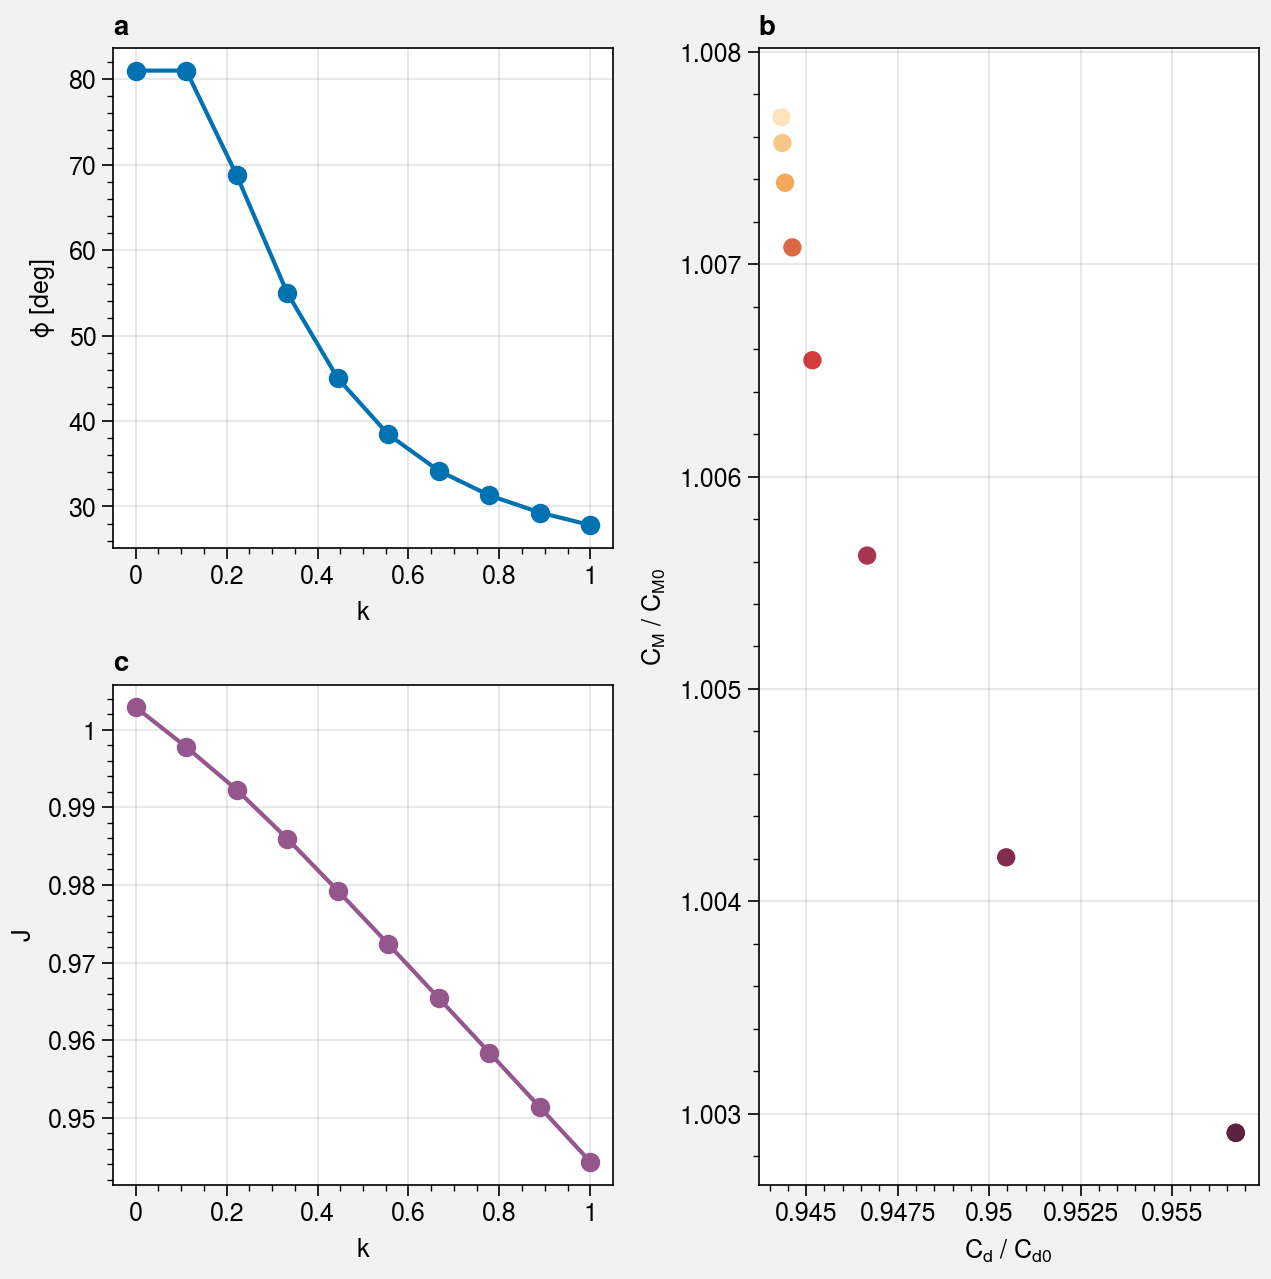

In [36]:
fig, axes = plot.subplots(array=[[1, 2], [3, 2]], sharex=False, sharey=False)

options = dict(marker="o")

axes[0].plot(results_df["$\\phi$"], **options)
axes[0].set_ylabel("$\\phi$ [deg]")

axes[1].scatter(
    results_df["cd"].values / optimizer.base_results[NAME_CD],
    results_df["cm"].values / optimizer.base_results[NAME_CM],
    c=results_df["J"],
)

axes[1].set_ylabel("$C_M$ / $C_{M0}$")
axes[1].set_xlabel("$C_d$ / $C_{d0}$")

axes[2].plot(results_df["J"], **options, c="purple")
axes[2].set_ylabel("J")

axes[0].format(abc=True)
axes[1].format(abc=True)
axes[2].format(abc=True)

fig.save("1d_optimization_results.png", dpi=300, bbox_inches="tight", transparent=True)